In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score, confusion_matrix, classification_report, precision_score, recall_score
from scipy.stats import spearmanr, kendalltau, pearsonr, shapiro

from matplotlib.ticker import MaxNLocator
import pingouin as pg
import random
%matplotlib inline

In [73]:
def patient_distance(df, ax, title, gt_dict, fontsize=20, xlabel=True, ylabel=True, markersize=5):
    df['gt_label_str'] = [gt_dict[int(i)] for i in df['label']]
    n_class = df['label'].max() + 1
    df_2img = df[df['img_per_patient'] > 1]
    for idx, label in enumerate(gt_dict.values()):
        ax.plot(df_2img[df_2img['label'] == idx]['patient_mean'], 
                df_2img[df_2img['label'] == idx]['patient_diff'], "o", label=label, markersize=markersize)
    ax.axhline(df_2img['patient_diff'].mean(), linestyle="--")
    ax.axhline(df_2img['patient_diff'].mean() - df_2img['patient_diff'].std() * 1.96, linestyle="--")
    ax.axhline(df_2img['patient_diff'].mean() + df_2img['patient_diff'].std() * 1.96, linestyle="--")
    if xlabel:
        ax.set_xlabel('Mean', fontsize=fontsize)
    if ylabel:
        ax.set_ylabel('Difference', fontsize=fontsize)
    if xlabel and ylabel:
        ax.legend(fontsize=fontsize+2, ncol=4, bbox_to_anchor=(3.7, -0.3), markerscale=4.)
    eps = 0.02
    ax.set_ylim(-np.round(df['score'].max()) - eps, min(n_class, np.round(df['score'].max())) + eps)
    ax.set_title(title, fontsize=fontsize+2)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize-3)

def print_metric(arr, name):
    print(f"{name}: {np.array(arr).mean()} +/- {(np.percentile(arr, 97.5) - np.percentile(arr, 2.5)) / 2} , CI: {np.percentile(arr, 2.5)}, {np.percentile(arr, 97.5)}")
        
        

def print_repeatability_metrics(df):
    # Repeatability
    df_2img = df[df['img_per_patient'] > 1]
    max_class = df.label.max()
    
    b = 500
    ids = df_2img.image.tolist()
    n = len(df_2img)

    not_normal = True
    while not_normal:
        diff = []
        loa = []
        dis = []
        for i in range(b):
            temp_df = df_2img.sample(n, replace=True)
            diff.append(abs(temp_df['patient_diff']).mean())
            loa.append(2 * temp_df['patient_diff'].std() * 1.96 / (2 * max_class))
            dis.append(len(temp_df[temp_df['disagreement'] > 1]) / len(temp_df))
        p_values = []
        for bootstrap in [diff, loa, dis]:
            stat, p = shapiro(bootstrap)
            p_values.append(p)
        print(p_values)
        not_normal = np.any(np.array(p_values) < 0.05)
        
    print_metric(diff, 'Avg. abs. diff.')
    print_metric(loa, 'LoA')
    print_metric(dis, 'disagreement rate')
    print('\n')

def get_auroc(df, pred, gt_colname):
    n_class = df[gt_colname].max()
    roc = []

    if n_class == 1:
        for i in range(2):
            fpr, tpr, thr = roc_curve(df[gt_colname].tolist(), df['auc' + str(i)])
            roc.append(auc(fpr, tpr))
        
    else:
        for i in range(2):
            pos = i if i == 0 else n_class
            fpr, tpr, thr = roc_curve(df[gt_colname].tolist(), df['auc' + str(i)], pos_label=pos)
            roc.append(auc(fpr, tpr))
    return roc
    
def print_classification_metrics(df, pred, gt_colname):
    # Classification
    # Bootstrap samples
    b = 500
    ids = df.image.tolist()
    n = len(df)
    
    not_normal = True
    while not_normal:
        acc = []
        k = []
        auc_normal = []
        auc_severe = []
        for i in range(b):
            temp_df = df.sample(n, replace=True)
            k.append(cohen_kappa_score(temp_df[gt_colname], temp_df.bin_pred, weights='quadratic'))
            acc.append((temp_df[gt_colname] == temp_df.bin_pred).sum() / len(temp_df))
            roc = get_auroc(temp_df, pred, gt_colname)
            auc_normal.append(roc[0])
            auc_severe.append(roc[1])
        p_values = []
        for bootstrap in [acc, k, auc_normal, auc_severe]:
            stat, p = shapiro(bootstrap)
            p_values.append(p)
        print(p_values)
        not_normal = np.any(np.array(p_values) < 0.05)
        
    icc = pg.intraclass_corr(data=df, targets='patient', raters='view', ratings='score', nan_policy='omit')
    
    print_metric(k, 'kappa')
    print_metric(acc, 'accuracy')
    print_metric(auc_normal, 'AUROC Normal')
    print_metric(auc_severe, 'AUROC Severe')

    print(f"icc: {np.array(icc.loc[icc.Type == 'ICC2k', 'ICC'].item()).mean()}, CI: {icc.loc[icc.Type == 'ICC2k', 'CI95%'].item()}")

    
def modify_pred_for_roc(df, pred, model_type):
    if model_type == 'binary':
        df['auc0'] = pred.flatten()
        df['auc1'] = pred.flatten()
    elif model_type == 'multi_class':
        df['auc0'] = pred[:, 0]
        df['auc1'] = pred[:, -1]
    elif model_type == 'ordinal':
        df['auc0'] = 1 - pred[:, 0]
        df['auc1'] = pred[:, 1]        
    elif model_type == 'regression':
        max_value = pred.max()
        df['auc0'] = max_value - pred[:, 0]
        df['auc1'] = pred[:, 0]        
        
    
def combine_by_patient(df, gt_colname='label'):
    diff = lambda x: x[0] - x[1]
    def get_abs_max(l):
        if len(l) < 1:
            return 0
        else:
            return max(l, key=abs)
        
#     df['var'] = get_mc_arr(df).var(0).mean(1)
    df = df.groupby('patient').agg(
    score=pd.NamedAgg(column='score', aggfunc='mean'),
    image=pd.NamedAgg(column='image', aggfunc='max'),
    label=pd.NamedAgg(column=gt_colname, aggfunc='mean'),
#     var=pd.NamedAgg(column='var', aggfunc='mean'),
    disagreement=pd.NamedAgg(column='bin_pred', aggfunc=lambda x: len(np.unique(x))),
    patient_diff=pd.NamedAgg(column='score', aggfunc=lambda x: get_abs_max(list(map(diff, list(itertools.combinations(x, 2)))))),
    patient_mean=pd.NamedAgg(column='score', aggfunc='mean'),
    img_per_patient=pd.NamedAgg(column=gt_colname, aggfunc=lambda x: len(x)),
    prediction=pd.NamedAgg(column='prediction', aggfunc=lambda x: list(np.array(x).mean(0))))
    
    df = df.explode('patient_diff')
    df['patient_diff'] = df['patient_diff'].astype('float')

    return df
 
def get_df_per_patient(df, pred, bin_pred, score, do_print=True, gt_colname='label', model_type=None):
    df['prediction'] = list(pred)
    df['score'] = score
    df['bin_pred'] = bin_pred

    if do_print:
        modify_pred_for_roc(df, pred, model_type)
        print_classification_metrics(df, pred, gt_colname)
    df = combine_by_patient(df, gt_colname)
    if do_print:
        print_repeatability_metrics(df)
    return df

def get_mc_pred(df, n_it=50):
    return get_mc_arr(df, n_it).mean(0)

def get_mc_arr(df, n_it=50):
    mc_pred = []
    for i in range(n_it):
        col_name = "mc_epistemic_" + str(i)
        mc_pred.append([eval(j) for j in df[col_name]])
    return np.array(mc_pred)


def get_classification_score(arr):
    return np.sum(arr * np.repeat(np.arange(1, arr.shape[-1] + 1)[None, ], arr.shape[0], axis=0), -1) - 1

def proba_to_label(probas):
    predict_levels = probas > 0.5
    predicted_labels = np.sum(predict_levels, axis=1)
    return predicted_labels

def binarize(pred, n_class=3):
    gt_max = pred.max()
    gt_min = min(pred.min(), 0)
    c_pred = []
    thr = [gt_min]
    for c in range(n_class - 1):
        new_thr = thr[c] + (gt_max-gt_min) / n_class
        thr.append(new_thr)
    thr.append(gt_max)
    for s in pred:
        for t in range(n_class):
            if (s[0] <= thr[t + 1]) and (s[0] >= thr[t]):
                c_pred.append(t)
                break
    return np.array(c_pred)


In [41]:
df_bin = pd.read_csv("cervix/bin.csv")
df_bin = df_bin[(df_bin.label == 0) | (df_bin.label == 2)]
df_bin.loc[df_bin.label == 2, 'label'] = 1

pred_binary = np.array([eval(j) for j in df_bin['pred']])


fpr, tpr, thr = roc_curve(df_bin['label'].tolist(), pred_binary.flatten())
auc(fpr, tpr)
# get_auroc(df_bin, pred_binary.flatten(), 'label')

0.8158380018674136

Binary
[0.6087220311164856, 0.9041702747344971, 0.6583812832832336, 0.6583812832832336]
kappa: 0.45702542286116365 +/- 0.07290985129536098 , CI: 0.38558568537149607, 0.531405387962218
accuracy: 0.7296484641638226 +/- 0.03713737201365186 , CI: 0.6928327645051194, 0.7671075085324232
AUROC Normal: 0.8146695366148567 +/- 0.03068555711160159 , CI: 0.7826130900541065, 0.8439842042773097
AUROC Severe: 0.8146695366148567 +/- 0.03068555711160159 , CI: 0.7826130900541065, 0.8439842042773097
icc: 0.8329575379516097, CI: [0.79 0.87]
[0.13683895766735077, 0.633041262626648, 0.2623654007911682]
Avg. abs. diff.: 0.19852505410825166 +/- 0.026890985085743918 , CI: 0.17121411400644088, 0.2249960841779287
LoA: 0.5985595160981807 +/- 0.06296782583957483 , CI: 0.5335033988048205, 0.6594390504839701
disagreement rate: 0.23096907216494844 +/- 0.05073024054982815 , CI: 0.18213058419243985, 0.28359106529209616


MC Binary
[0.07658340036869049, 0.14025743305683136, 0.010234711691737175, 0.010234711691737175]
[0

/home/andreanne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


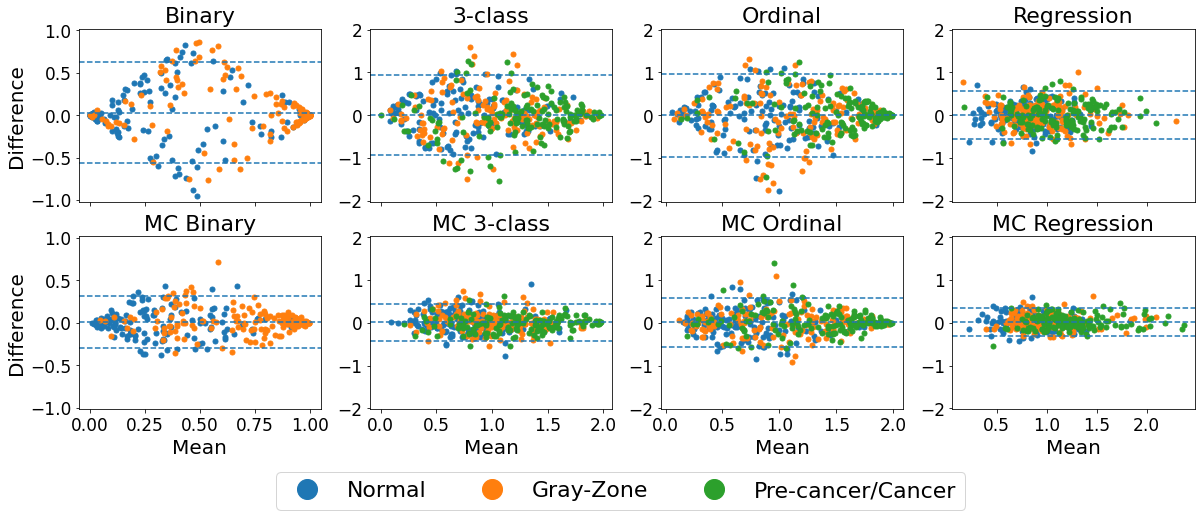

In [42]:
# Load cervix test result files
df_van = pd.read_csv("cervix/van.csv")
df_mc = pd.read_csv("cervix/mc.csv")
df_bin = pd.read_csv("cervix/bin.csv")
df_bin = df_bin[(df_bin.label == 0) | (df_bin.label == 2)]
df_bin.loc[df_bin.label == 2, 'label'] = 1
df_mcbin = pd.read_csv("cervix/mc_bin.csv")
df_mcbin = df_mcbin[(df_mcbin.label == 0) | (df_mcbin.label == 2)]
df_mcbin.loc[df_mcbin.label == 2, 'label'] = 1
df_ord = pd.read_csv("cervix/ordinal.csv")
df_mcord = pd.read_csv("cervix/mc_ordinal.csv")
df_reg = pd.read_csv("cervix/reg.csv")
df_mcreg = pd.read_csv("cervix/mc_reg.csv")

fig, ax = plt.subplots(2, 4, sharex='col', sharey='col')
fig.set_size_inches(20, 7)

cervix_gt_dict = {0: 'Normal', 1: 'Gray-Zone', 2: 'Pre-cancer/Cancer'}

def generate_results(df_lst, gt_dict, figname, gt_colname='label', markersize=5):
    df_bin, df_mcbin, df_van, df_mc, df_ord, df_mcord, df_reg, df_mcreg = df_lst
    
    # Binary
    print('Binary')
    pred_binary = np.array([eval(j) for j in df_bin['pred']])
    df_bin_c = get_df_per_patient(df_bin, pred_binary, binarize(pred_binary, 2), pred_binary, gt_colname=gt_colname, model_type='binary')
    patient_distance(df_bin_c, ax[0, 0], 'Binary', gt_dict, xlabel=False, ylabel=True, markersize=markersize)

    # MC Binary
    print('MC Binary')
    pred_mc_binary = get_mc_pred(df_mcbin, n_it=50)
    # pred_mc_binary = np.array([eval(j) for j in df_mcbin['pred']])
    df_mcbin_c = get_df_per_patient(df_mcbin, pred_mc_binary, binarize(pred_mc_binary, 2), pred_mc_binary, gt_colname=gt_colname, model_type='binary')
    patient_distance(df_mcbin_c, ax[1, 0], 'MC Binary', gt_dict, xlabel=True, ylabel=True, markersize=markersize)

    # Vanilla
    print('Vanilla')
    pred_van = np.array([eval(j) for j in df_van['pred']])
    df_van_c = get_df_per_patient(df_van, pred_van, pred_van.argmax(1), get_classification_score(pred_van), gt_colname=gt_colname, model_type='multi_class')
    patient_distance(df_van_c, ax[0, 1], '3-class', gt_dict, xlabel=False, ylabel=False, markersize=markersize)

    # MC
    print('MC')
    pred_mc = get_mc_pred(df_mc, n_it=50)
    # pred_mc = np.array([eval(j) for j in df_mc['pred']])
    df_mc_c = get_df_per_patient(df_mc, pred_mc, pred_mc.argmax(1), get_classification_score(pred_mc), gt_colname=gt_colname, model_type='multi_class')
    patient_distance(df_mc_c, ax[1, 1], 'MC 3-class', gt_dict, xlabel=True, ylabel=False, markersize=markersize)
    
    # Ordinal
    print('Ordinal')
    pred_ord = np.array([eval(j) for j in df_ord['pred']])
    df_ord_c = get_df_per_patient(df_ord, pred_ord, proba_to_label(pred_ord), pred_ord.sum(1), gt_colname=gt_colname, model_type='ordinal')
    patient_distance(df_ord_c, ax[0, 2], 'Ordinal', gt_dict, xlabel=False, ylabel=False, markersize=markersize)

    # MC Ordinal
    print('MC Ordinal')
    pred_mc_ord = get_mc_pred(df_mcord, n_it=50)
    # pred_mc_ord = np.array([eval(j) for j in df_mcord['pred']])
    df_mcord_c = get_df_per_patient(df_mcord, pred_mc_ord, proba_to_label(pred_mc_ord), pred_mc_ord.sum(1), gt_colname=gt_colname, model_type='ordinal')
    patient_distance(df_mcord_c, ax[1, 2], 'MC Ordinal', gt_dict, xlabel=True, ylabel=False, markersize=markersize)


    # Regression
    print('Regression')
    pred_reg = np.array([eval(j) for j in df_reg['pred']])
    n_class = len(df_reg[gt_colname].unique())
    df_reg_c = get_df_per_patient(df_reg, pred_reg, binarize(pred_reg, n_class), pred_reg, gt_colname=gt_colname, model_type='regression')
    patient_distance(df_reg_c, ax[0, 3], 'Regression', gt_dict, xlabel=False, ylabel=False, markersize=markersize)

    # MC Regression
    print('MC Regression')
    pred_mc_reg = get_mc_pred(df_mcreg, n_it=50)
    # pred_mc_reg = np.array([eval(j) for j in df_mcreg['pred']])
    df_mcreg_c = get_df_per_patient(df_mcreg, pred_mc_reg, binarize(pred_mc_reg, n_class), pred_mc_reg, gt_colname=gt_colname, model_type='regression')
    patient_distance(df_mcreg_c, ax[1, 3], 'MC Regression', gt_dict, xlabel=True, ylabel=False, markersize=markersize)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    fig.savefig(figname, bbox_inches='tight')
    
df_lst = [df_bin, df_mcbin, df_van, df_mc, df_ord, df_mcord, df_reg, df_mcreg]


generate_results(df_lst, cervix_gt_dict, "cervix_bland_altman.png")

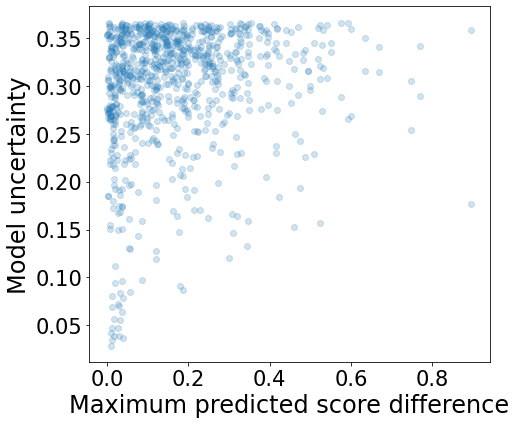

In [46]:
df_mc = pd.read_csv("cervix/mc.csv")

def plot_uncertainty_diff(df_mc, gt_colname='label', ylim=None, name=None):
    fontsize=24
    fig, ax = plt.subplots(1)
    fig.set_size_inches(7, 6)
    pred_mc = get_mc_pred(df_mc, n_it=50)
    
    df_mc['unc'] = -(pred_mc * np.log(pred_mc)).mean(1)
    df_mc_c = get_df_per_patient(df_mc, pred_mc, pred_mc.argmax(1), get_classification_score(pred_mc), gt_colname=gt_colname, do_print=False)

    df_mc['diff'] = None
    for p in df_mc_c.index:
        df_mc.loc[df_mc['patient'] == p, 'diff'] = df_mc_c.loc[df_mc_c.index == p, 'patient_diff'].item()
        

    ax.scatter(abs(df_mc['diff']), df_mc['unc'],  alpha=0.2)
    ax.set_ylabel("Model uncertainty", fontsize=fontsize)
    ax.set_xlabel("Maximum predicted score difference", fontsize=fontsize)
    if ylim:
        ax.set_ylim(-0.02 * ylim, ylim)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize-3)
    plt.tight_layout()
    fig.savefig(name, bbox_inches='tight')

plot_uncertainty_diff(df_mc, name='cervix_unc.png')

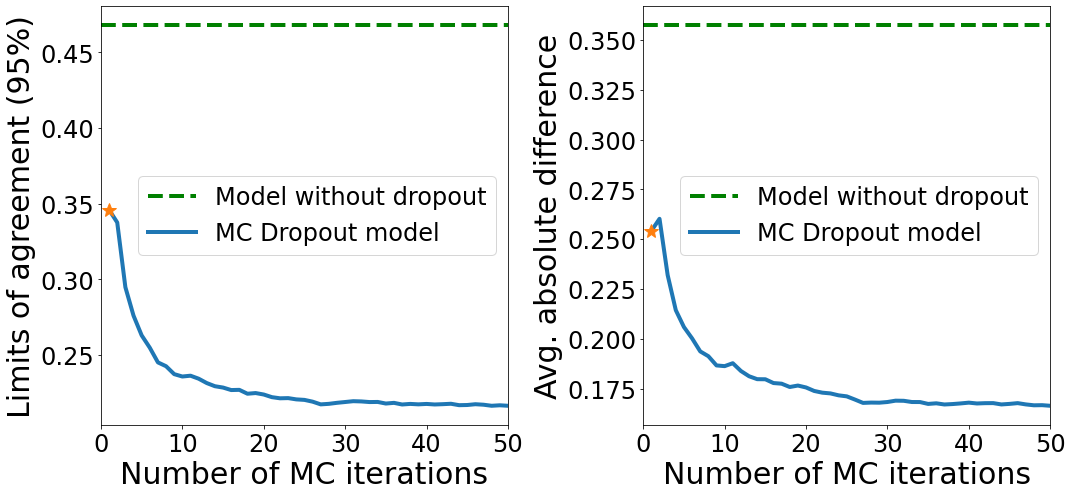

In [43]:
def get_disagreement_rate(df):
    df_2img = df[df['img_per_patient'] > 1]
    return len(df_2img[df_2img['disagreement'] > 1]) / len(df_2img)

def get_loa(df):
    df_2img = df[df['img_per_patient'] > 1]
    return 2 * df_2img['patient_diff'].std() * 1.96 / (df.label.max() * 2)

def get_avg_abs_diff(df):
    df_2img = df[df['img_per_patient'] > 1]
    return abs(df_2img['patient_diff']).mean()

def get_icc(df):
    icc = pg.intraclass_corr(data=df, targets='patient', raters='view',
                         ratings='score', nan_policy='omit')
    return icc.loc[icc.Type == 'ICC2k', 'ICC'].item()

def get_score_ordinal(pred):
    return pred.sum(1)

def get_score_regression(pred):
    return pred

def get_score_classification(pred):
    return get_classification_score(pred)

def get_bin_ordinal(pred):
    return proba_to_pred(pred)

def get_bin_regression(pred):
    return binarize(pred)

def get_bin_classification(pred):
    return pred.argmax(1)

def mc_it_analysis(df, df_nonmc, bin_pred_func, bin_score_func, figname, gt_colname='label'):
    eval_metrics = [get_disagreement_rate, get_loa, get_avg_abs_diff]

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 7)

    loa = []
    dis = []
    diff = []
#     icc = []
    for it in range(1, 51):
        if it == 1:
            pred = np.array([eval(j) for j in df['pred']])
        else:
            pred = get_mc_pred(df, n_it=it)

#         icc.append(get_icc(df))
        combined_df = get_df_per_patient(df, pred, bin_pred_func(pred), bin_score_func(pred), False, gt_colname=gt_colname)
        loa.append(get_loa(combined_df))
        dis.append(get_disagreement_rate(combined_df))
        diff.append(get_avg_abs_diff(combined_df))

    pred_ = np.array([eval(j) for j in df_nonmc['pred']])
#     non_mc_icc = get_icc(df_nonmc)
    df_c = get_df_per_patient(df_nonmc, pred_, bin_pred_func(pred_), bin_score_func(pred_), False, gt_colname=gt_colname)        
    non_mc_loa = get_loa(df_c)
    non_mc_dis = get_disagreement_rate(df_c)
    non_mc_diff = get_avg_abs_diff(df_c)

    for idx, (m, nm) in enumerate(zip([loa, diff], [non_mc_loa, non_mc_diff])):
        ax[idx].set_xlim(0, 50)
        ax[idx].axhline(nm, linestyle="--", label='Model without dropout', linewidth=4, color='g')
        ax[idx].plot(range(1, 51), m, label='MC Dropout model', linewidth=4)
        # label='Dropout model prediction \n(dropout disabled at test time)'
        ax[idx].plot(1, m[0], '*', markersize=15)
    
        ax[idx].set_xlabel('Number of MC iterations', fontsize=30)
        ax[idx].legend(fontsize=24)

#     ax[0].set_ylabel('Disagreement rate', fontsize=22)
    ax[0].set_ylabel('Limits of agreement (95%)', fontsize=30)
    ax[1].set_ylabel('Avg. absolute difference', fontsize=30)
    for i in range(2):
        for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            label.set_fontsize(24)
    plt.tight_layout()
    fig.savefig(figname)
mc_it_analysis(df_mc, df_van, get_bin_classification, get_score_classification, 'mc_cervix.png')

In [49]:
# Load mammo test result files
df_van = pd.read_csv("mammo/vanilla.csv")
df_mc = pd.read_csv("mammo/mc.csv")
df_bin = pd.read_csv("mammo/bin.csv")
df_mcbin = pd.read_csv("mammo/mc_bin.csv")
df_ord = pd.read_csv("mammo/ordinal.csv")
df_mcord = pd.read_csv("mammo/mc_ord.csv")
df_reg = pd.read_csv("mammo/regression.csv")
df_mcreg = pd.read_csv("mammo/mc_reg.csv")

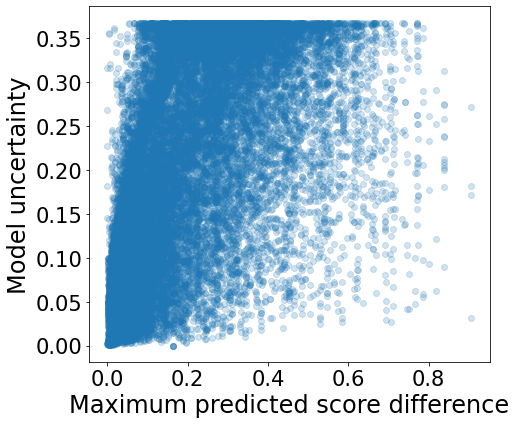

In [50]:
df_mcbin = pd.read_csv("mammo/mc_bin.csv")
plot_uncertainty_diff(df_mcbin, gt_colname='density', name='mammo_unc.png')

Binary
[0.1897103190422058, 0.09668336808681488, 0.10414904356002808, 0.10414904356002808]
kappa: 0.6833410494908972 +/- 0.008484451994018205 , CI: 0.6744748327447265, 0.6914437367327629
accuracy: 0.8440814847678203 +/- 0.004058987725524987 , CI: 0.839745082815735, 0.847863058266785
AUROC Normal: 0.923431657170862 +/- 0.002796539371339668 , CI: 0.9204846747929587, 0.926077753535638
AUROC Severe: 0.923431657170862 +/- 0.002796539371339668 , CI: 0.9204846747929587, 0.926077753535638
icc: 0.9753646965720266, CI: [0.97 0.98]
[0.7668032646179199, 0.46755221486091614, 0.8579546809196472]
Avg. abs. diff.: 0.20558025630553703 +/- 0.005168067075395744 , CI: 0.20061294344862315, 0.21094907759941464
LoA: 0.5496593500999868 +/- 0.011881515685718325 , CI: 0.5379527982847373, 0.561715829656174
disagreement rate: 0.2207241950321987 +/- 0.010811867525298988 , CI: 0.20993560257589697, 0.23155933762649494


MC Binary
[0.15124662220478058, 0.20392221212387085, 0.1455615907907486, 0.1455615907907486]
kapp

/home/andreanne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


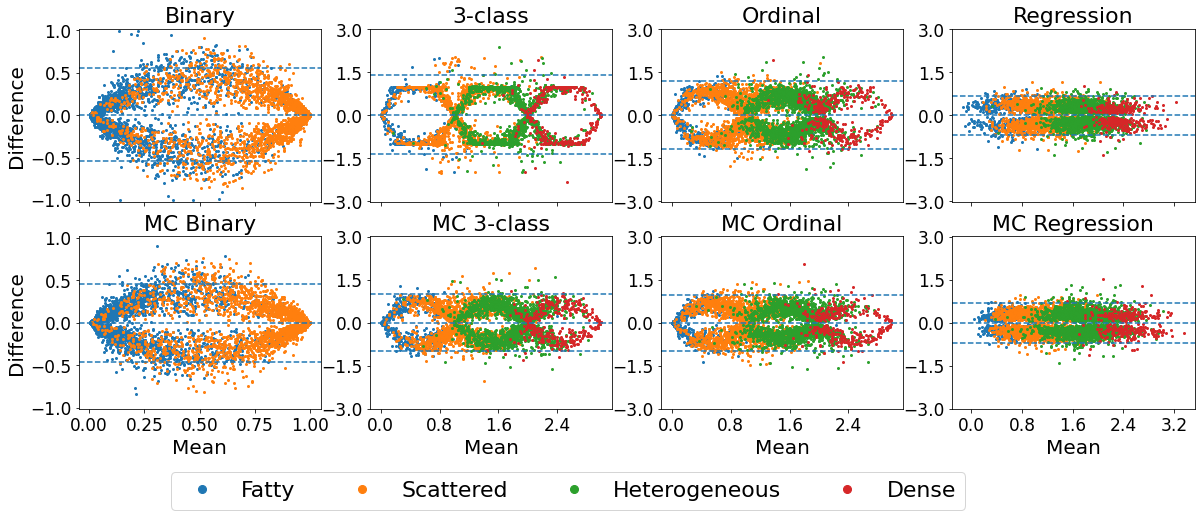

In [51]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='col')
fig.set_size_inches(20, 7)

df_lst = [df_bin, df_mcbin, df_van, df_mc, df_ord, df_mcord, df_reg, df_mcreg]
mammo_gt_dict = {0: 'Fatty', 1: 'Scattered', 2: 'Heterogeneous', 3: "Dense"}
generate_results(df_lst, mammo_gt_dict, "mammo_bland_altman.png", 'density', markersize=2)


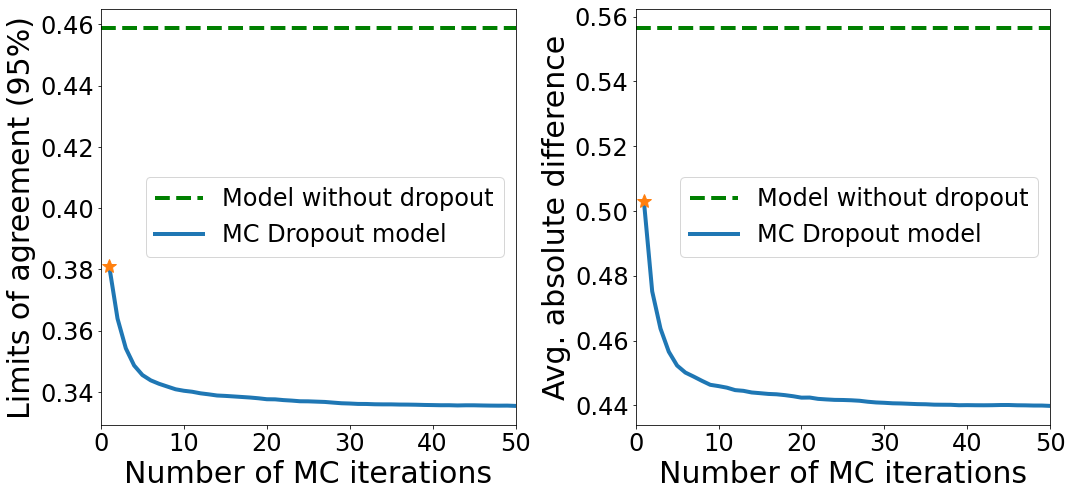

In [137]:
df_van = pd.read_csv("mammo/vanilla.csv")
df_mc = pd.read_csv("mammo/mc.csv")

mc_it_analysis(df_mc, df_van, get_bin_classification, get_score_classification, 'mc_mammo.png', 'density')

Binary
[0.11243180185556412, 0.36968210339546204, 0.13454139232635498]
kappa: 0.5008966021810682 +/- 0.050476246641116274 , CI: 0.4512841546047782, 0.5522366478870108
accuracy: 0.8172663690476191 +/- 0.019363839285714224 , CI: 0.7987165178571429, 0.8374441964285714
AUROC Normal: 0.8839065411543585 +/- 0.02306337471594827 , CI: 0.8605103621755124, 0.9066371116074089
AUROC Severe: 0.8839065411543585 +/- 0.02306337471594827 , CI: 0.8605103621755124, 0.9066371116074089
icc: 0.8227908938723801, CI: [0.79 0.85]
[0.7108986377716064, 0.5826675891876221, 0.13833403587341309]
Avg. abs. diff.: 0.29833049800847833 +/- 0.029411910942178487 , CI: 0.2681629039882441, 0.3269867258726011
LoA: 0.8377633966237501 +/- 0.05689971348724859 , CI: 0.7812394323227947, 0.8950388592972919
disagreement rate: 0.3200088888888889 +/- 0.04280555555555554 , CI: 0.27661111111111114, 0.3622222222222222


MC Binary
[0.07351231575012207, 0.4489539861679077, 0.021059343591332436]
[0.6121038198471069, 0.6589533090591431, 0.

/home/andreanne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


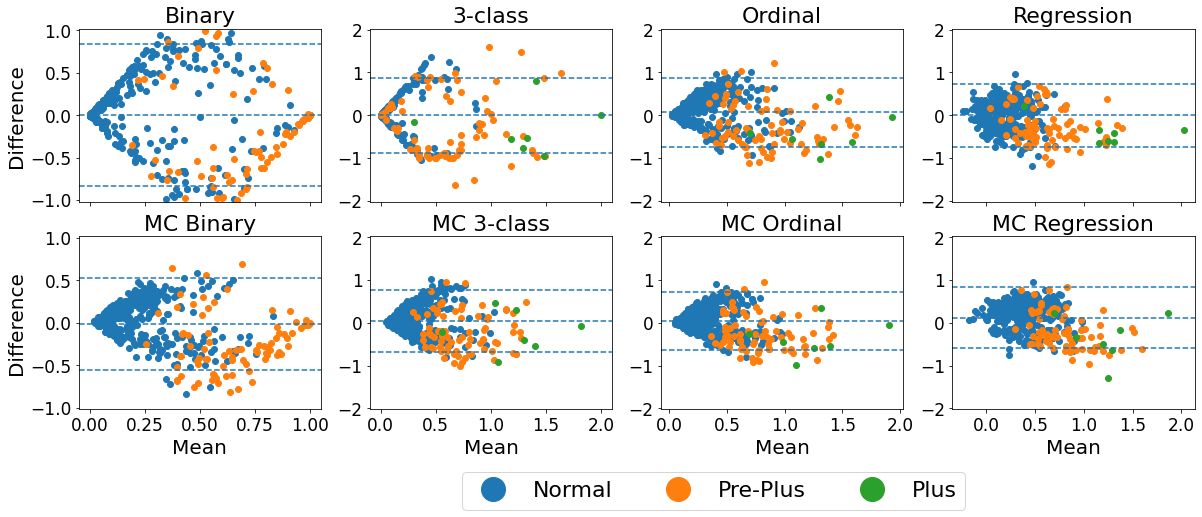

In [74]:
# Load mammo test result files
df_van = pd.read_csv("rop/van.csv")
df_mc = pd.read_csv("rop/mc.csv")
df_bin = pd.read_csv("rop/bin.csv")
df_bin.loc[df_bin['label'] == 2, 'label'] = 1
df_mcbin = pd.read_csv("rop/mc_bin.csv")
df_mcbin.loc[df_mcbin['label'] == 2, 'label'] = 1
df_ord = pd.read_csv("rop/ord.csv")
df_mcord = pd.read_csv("rop/mc_ord.csv")
df_reg = pd.read_csv("rop/reg.csv")
df_mcreg = pd.read_csv("rop/mc_reg.csv")

fig, ax = plt.subplots(2, 4, sharex='col', sharey='col')
fig.set_size_inches(20, 7)

df_lst = [df_bin, df_mcbin, df_van, df_mc, df_ord, df_mcord, df_reg, df_mcreg]
path_lst = ["rop/bin.csv", "rop/mc_bin.csv", "rop/van.csv", "rop/mc.csv", "rop/ord.csv", "rop/mc_ord.csv", "rop/reg.csv", "rop/mc_reg.csv"]

gt_dict = {0: 'Normal', 1: 'Pre-Plus', 2: 'Plus'}
generate_results(df_lst, gt_dict, "rop_bland_altman.png", markersize=6)


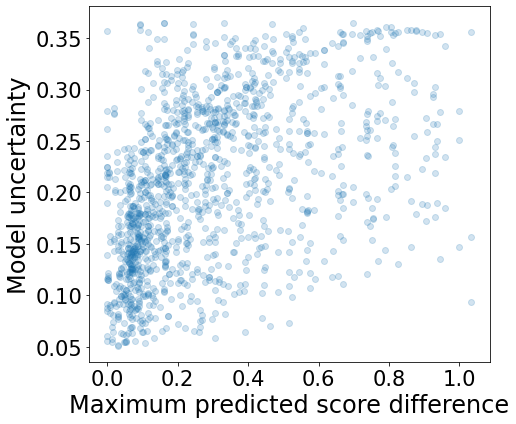

In [273]:
df_mc = pd.read_csv("rop/mc.csv")

plot_uncertainty_diff(df_mc, gt_colname='label', name='rop_unc.png')